**Predicting the best players by strength of players for playing positions**

**The Problem:** The client, a famous European Football Club wants to have a list of players to consider during transfer season. In case they need to make a transfer, they will bring in a replacement. A major part of player selection depends upon which position the player will play at. Depending on the need of the team, the managers will consider the up and coming players who will suit their need. The client requires us to build an algorithm that will predict the best 20 players for each specific position

**The Solution:** 

**Data:** The data we will use for this problem is sourced from several websites such as 

http://football-data.mx-api.enetscores.com/ : scores, lineup, team formation and events

http://www.football-data.co.uk/ : betting odds

http://sofifa.com/ : players and teams attributes from EA Sports FIFA games. FIFA series and all FIFA assets property of EA Sports;
by Hugomathien and made available on Kaggle at https://www.kaggle.com/hugomathien/soccer

**Cleaning:** 
1. From the available database, we use the tables 'players' and 'player_attributes' and identify each players preferred position of playing using their X, Y playing coordinates. We create a table of player_positions to make merging of datasets easier
2. After merging all the available datasets, we keep only the features we need to predict the performance for a player. We use the feature 'overall_rating' given by FIFA and we calculate the age of each player for the same rating date. This is to understand whether age of the player has impact on player performance. Alternatively, we can also collect rating for each player on the latest date available for the player and use that to correlate age and overall_rating
3. We check this data for missing and incorrect values and clean it

**Descriptive Analytics:**
1. Test the correlation of age with overall rating and fit a model to predict rating for each player position
2. Also test additional data from player attributes dataset like player strength, height, weight etc. to check for correlation with score (overall_rating)

**Modeling:**
1. For each position, check assumptions, hypotheses and test
2. Fit a suitable model on training data and test on testing data


Step 1: Importing the data and packages required

In [1]:
#import packages
import os
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
#formatting for table displays
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
#connection to database
with sqlite3.connect('/Users/ruhama.ahale/Documents/git_repository/capstone-project/database_with_player_positions.sqlite') as con:
    #countries = pd.read_sql_query("SELECT * from Country", con)
    #matches = pd.read_sql_query("SELECT * from Match", con)
    #leagues = pd.read_sql_query("SELECT * from League", con)
    #teams = pd.read_sql_query("SELECT * from Team", con)
    player_attributes = pd.read_sql_query("SELECT * from Player_Attributes", con)
    player_positions = pd.read_sql_query("SELECT * from Player_Positions", con)
    player = pd.read_sql_query("SELECT * from Player", con)

Step 2: Joining selected table to create final data table

In [4]:
player.head(3)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163


In [143]:
player_attributes.head(3)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0


In [144]:
player_positions.head(3)

,player_api_id,player_name,matches_played,matches_played_in_position,preferred_x_position,preferred_y_position,player_position
0,505942,Aaron Appindangoye,8,8,6,3,Center Back
1,155782,Aaron Cresswell,75,75,8,3,Left Back
2,162549,Aaron Doran,104,78,2,7,Right Winger


In [5]:
#merge all player files to get the player details required
player_positions = player_positions[['player_api_id', 'player_name', 'player_position']]
player_attributes_new = player_attributes[['player_api_id','date', 'overall_rating']]
player_attributes_new = player_positions.merge(player_attributes_new,on='player_api_id')
player = player[['player_api_id', 'birthday', 'height', 'weight']]
player_attributes_new = player_attributes_new.merge(player,on='player_api_id')
player_attributes_new['birthday_date'] = pd.to_datetime(player_attributes_new['birthday'])
player_attributes_new['date'] = pd.to_datetime(player_attributes_new['date'])
player_attributes_new['age'] = player_attributes_new['date'] - player_attributes_new['birthday_date']
player_attributes_new['age'] = player_attributes_new['age'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)
player_attributes_new['age'] = round(player_attributes_new['age']/365,0)
player_attributes_new = player_attributes_new[player_attributes_new.date >= '2009-07-31']


In [146]:
player_attributes_new.head(3)

,player_api_id,player_name,player_position,date,overall_rating,birthday,height,weight,birthday_date,age
0,505942,Aaron Appindangoye,Center Back,2016-02-18,67.0,1992-02-29 00:00:00,182.88,187,1992-02-29,24.0
1,505942,Aaron Appindangoye,Center Back,2015-11-19,67.0,1992-02-29 00:00:00,182.88,187,1992-02-29,24.0
2,505942,Aaron Appindangoye,Center Back,2015-09-21,62.0,1992-02-29 00:00:00,182.88,187,1992-02-29,24.0


In [6]:
#number of unique player in our new database
player_attributes_new.player_api_id.nunique()

10867

In [13]:
#save data to csv
df = pd.DataFrame(player_attributes_new)
df.to_csv('player_attributes_new.csv', sep=',', encoding='utf-8')

In [148]:
#count unique players in each position
player_attributes_new.groupby(player_attributes_new.player_position).player_api_id.nunique()

player_position
Attacking Midfielder    1006
Center Back             1773
Center Forward          1664
Central Midfielder      1758
Goalkeeper               940
Left Back                882
Left Forward             217
Left Midfielder          281
Left Winger              359
RIght Midfielder         328
Right Back               985
Right Forward            228
Right Winger             446
Name: player_api_id, dtype: int64

In [149]:
#select data for one position for analysis
left_back = player_attributes_new[(player_attributes_new.player_position== 'Left Back')]
left_back_avg = left_back.groupby(left_back.player_api_id).mean()
left_back_avg.head()

,overall_rating,height,weight,age
player_api_id,,,,
2790,70.000000,175.26,163,36.500000
3316,65.555556,180.34,159,32.222222
8930,66.428571,182.88,170,28.285714
11242,63.375000,177.80,174,25.062500
11327,68.600000,162.56,146,31.800000


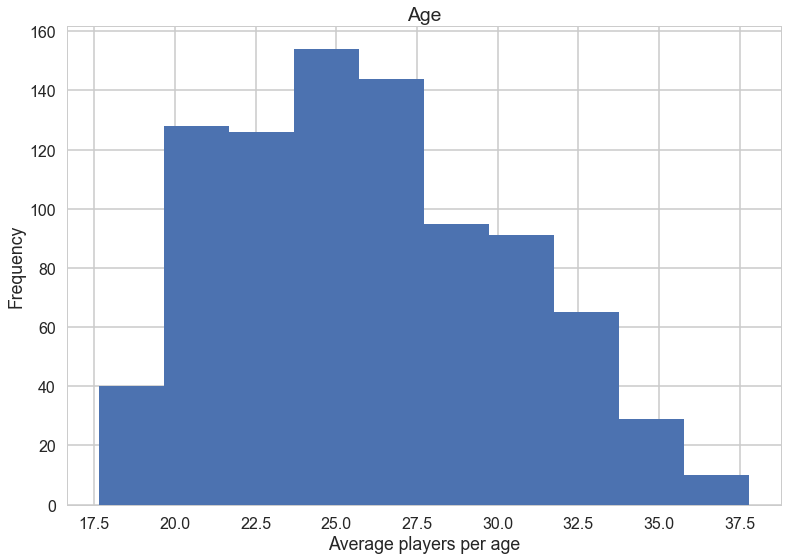

In [138]:
#plot for mean age
plt.hist(left_back_avg.age)
plt.title("Age")
plt.xlabel("Average players per age")
plt.ylabel("Frequency")
plt.show()

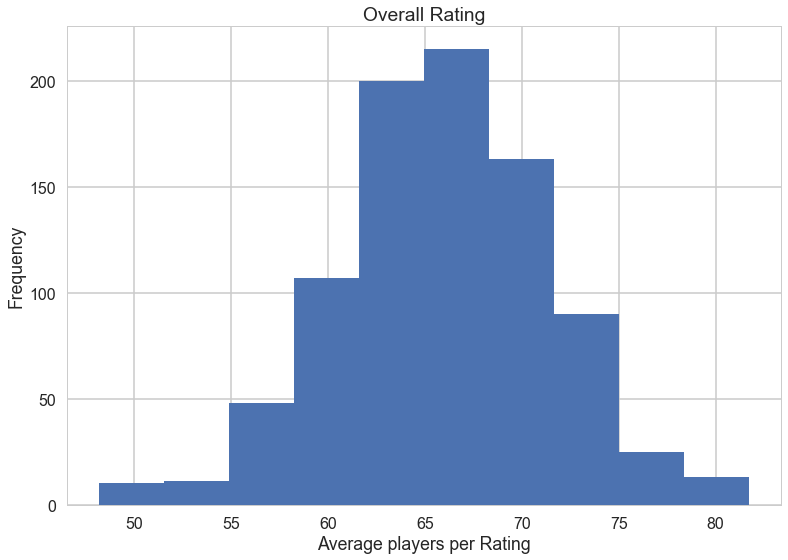

In [150]:
#plot for mean overall_rating
plt.hist(left_back_avg.overall_rating)
plt.title("Overall Rating")
plt.xlabel("Average players per Rating")
plt.ylabel("Frequency")
plt.show()

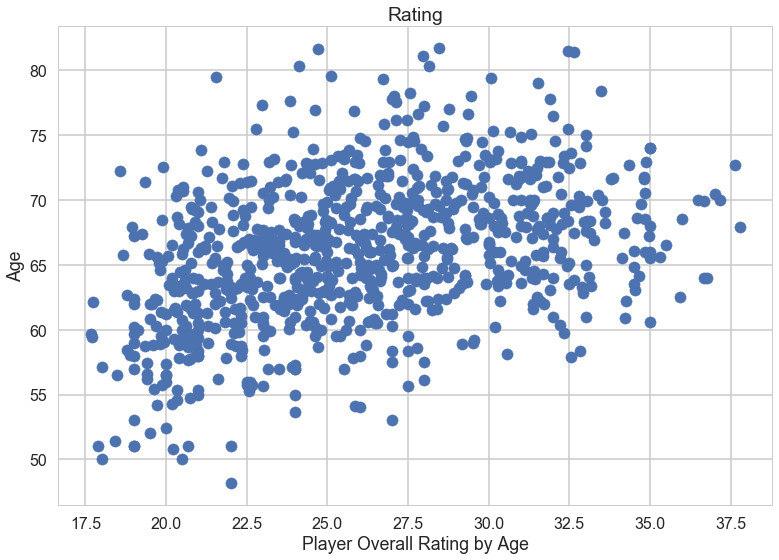

In [139]:
#Scatter plot to check relationship between age and rating
plt.scatter(left_back_avg.age, left_back_avg.overall_rating)
plt.xlabel("Player Overall Rating by Age")
plt.ylabel("Age")
plt.title("Rating")

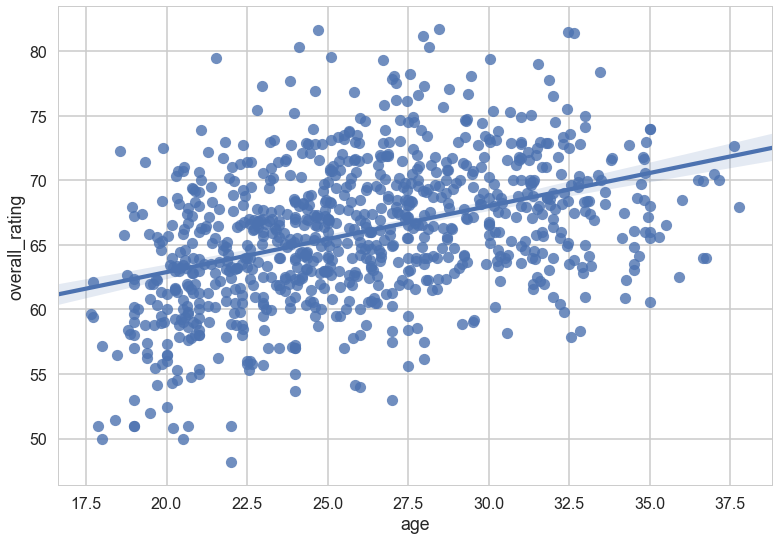

In [140]:
sns.regplot(y="overall_rating", x="age", data=left_back_avg, fit_reg = True)